In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('whitegrid')

In [2]:
OVERHEAD = 0.1
RESULT_DIR = '../../results-new-sliced/'
# RESULTS_PATH = RESULT_DIR + '/exp-gap_600-real_mean_over=0.1.csv'
# RESULTS_PATH = RESULT_DIR + '/exp-gap_60-real_mean_over=0.1.csv'
RESULTS_PATH = RESULT_DIR + f'/real_overhead={OVERHEAD}.csv'
# RESULTS_PATH = f'../results/exp_real_mean_overhead={OVERHEAD}.csv'


df = pd.read_csv(RESULTS_PATH, sep='\t')
df = df[df['algorithm'] != 'group_time_sliced']

greedy_record = df[df['algorithm'] == 'greedy'].to_dict(orient='records')[0]
greedy_record['algorithm'] = 'time_sliced'
df = df.append(greedy_record, ignore_index=True)
greedy_record['algorithm'] = 'loose_time_sliced'
df = df.append(greedy_record, ignore_index=True)
df['slice_cnt'] = 52. / df['slice interval'].astype(float)
origin_df = df.copy()

/tmp/ipykernel_20008/3060221203.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(greedy_record, ignore_index=True)
/tmp/ipykernel_20008/3060221203.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(greedy_record, ignore_index=True)


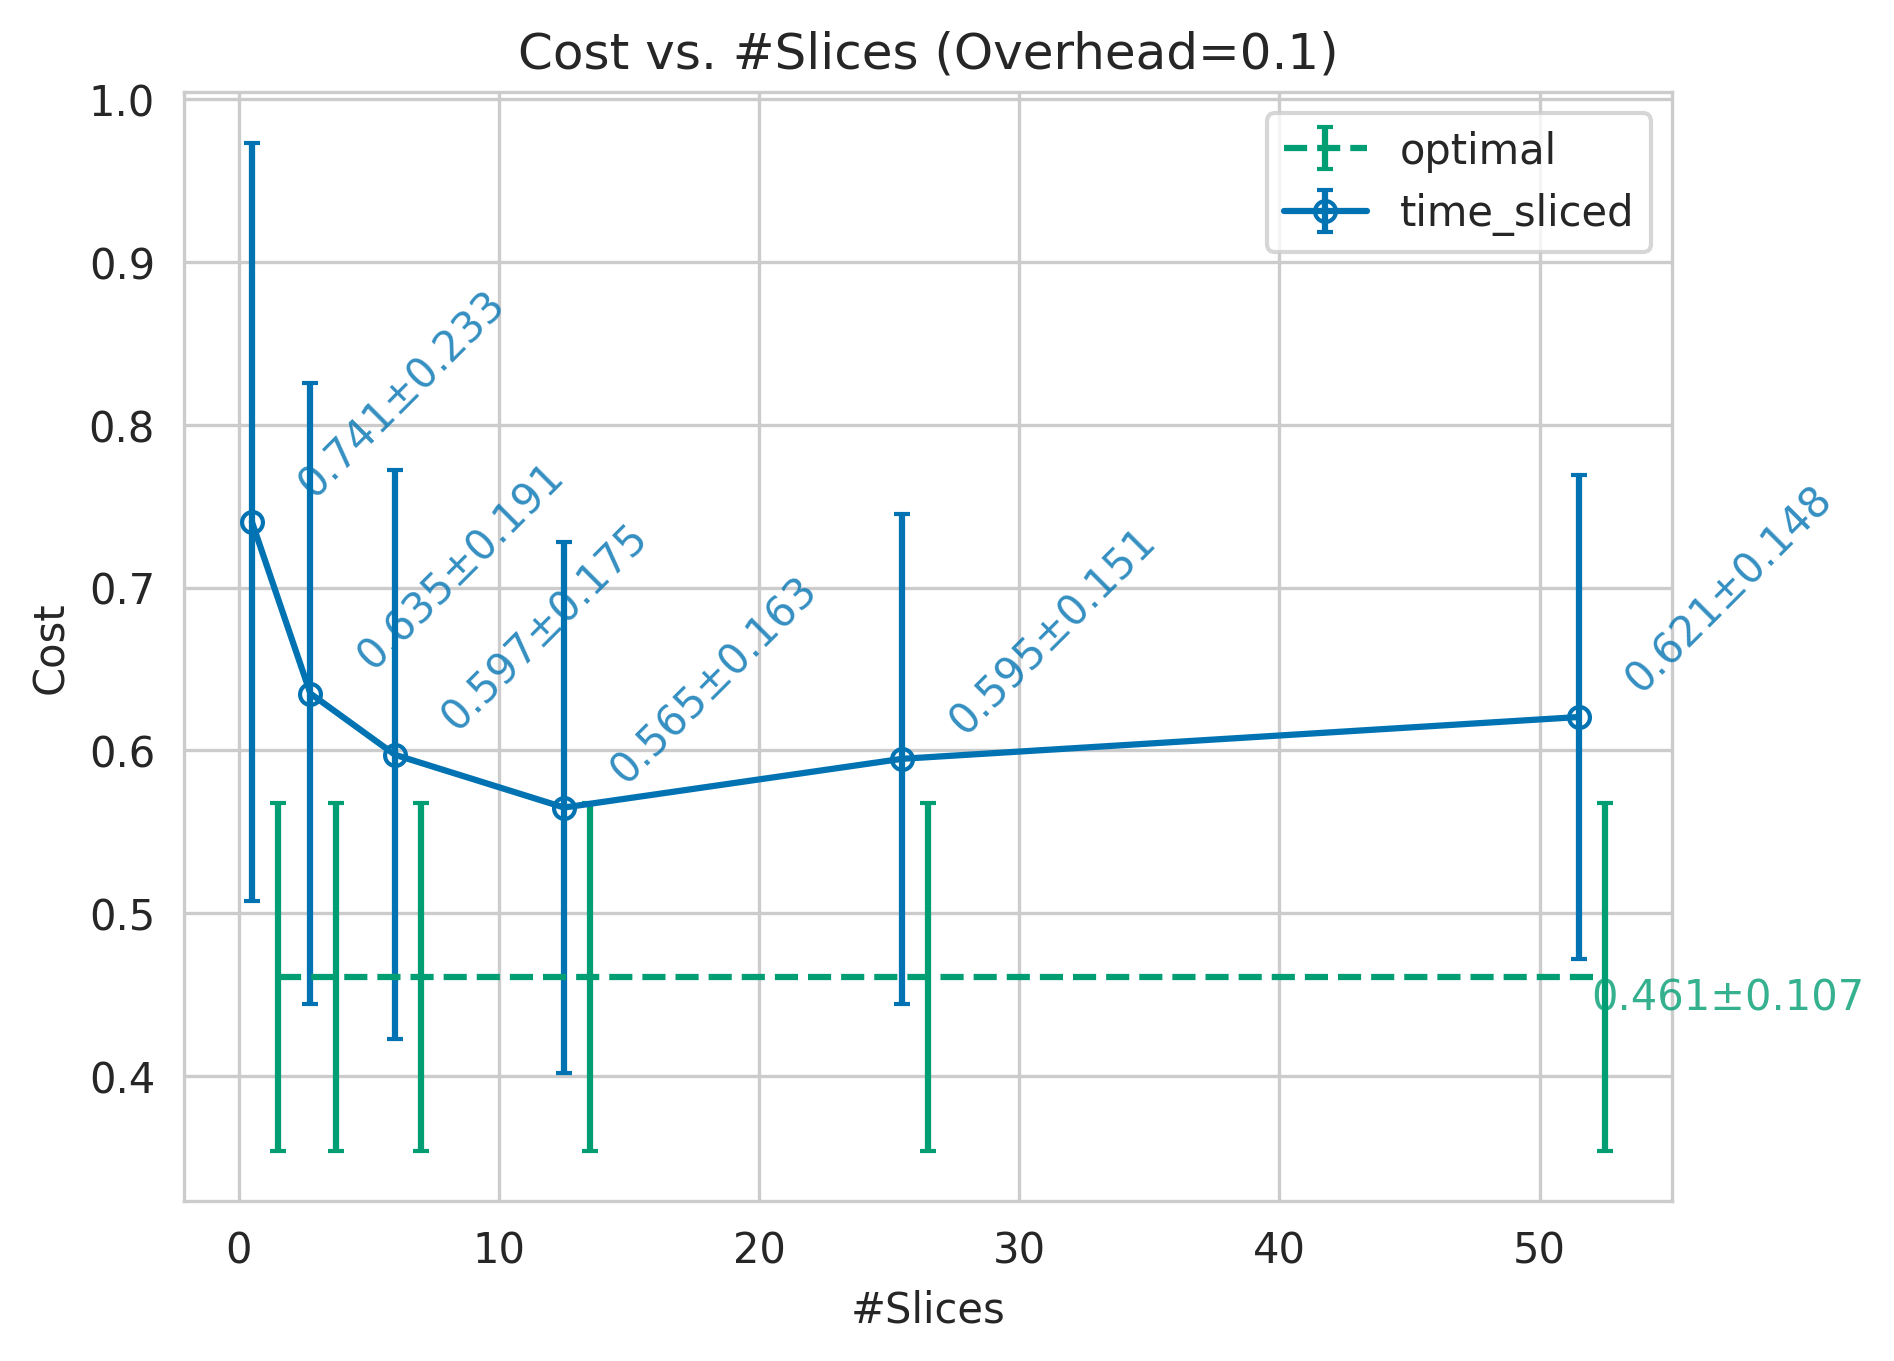

In [3]:
# ALGORITHMS = ['time_sliced', 'loose_time_sliced']
ALGORITHMS = ['time_sliced']
df = df[~df['use_avg']]
if 'max slice slacks' in df.columns:
    df = df[df['max slice slacks'].isna()]
    df = df[df['max total slacks'].isna()]
time_sliced = df[df['algorithm'] == 'time_sliced']
loose_time_sliced = df[df['algorithm'] == 'loose_time_sliced']
slice_cnts = df['slice_cnt'].unique()
slice_cnts.sort()

CAPSIZE = 2
SHIFT = 0.5
ANNOTATE_ALPHA = 0.8

palette = sns.color_palette('colorblind')
colors = {
    'time_sliced': palette[0],
    'loose_time_sliced': palette[1],
    'ideal_ilp': palette[2],
}
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
ideal = df[df['algorithm'] == 'ideal_ilp']
y_ideal = None
if len(ideal):
    y_ideal = ideal['mean'].values[0]
    ideal_std = ideal['std'].values[0]
    # sns.lineplot(x=slice_cnts,
    #             y=[y_ideal] * len(slice_cnts),
    #             label='optimal',
    #             errorbar=None,
    #             ax=ax, color=palette[-1], linestyle='--')
    ax.errorbar(slice_cnts + SHIFT, [y_ideal] * len(slice_cnts),
                [ideal_std] * len(slice_cnts),
                alpha=1,
                color=colors['ideal_ilp'],
                ls='--',
                capsize=CAPSIZE,
                label='optimal')
    ax.text(slice_cnts[-1], y_ideal - 0.02, f'{y_ideal:.3f}±{ideal_std:.3f}', color=colors['ideal_ilp'], alpha=ANNOTATE_ALPHA)
# ax = sns.lineplot(x='slice_cnt', y='mean', hue='algorithm', data=df[df['algorithm'].isin(ALGORITHMS)], errorbar=None, style='algorithm', markers='*', markersize=10., markeredgecolor=None, dashes=False, palette=palette)
ax.errorbar(time_sliced['slice_cnt'] - SHIFT,
            time_sliced['mean'],
            time_sliced['std'],
            alpha=1,
            color=colors['time_sliced'],
            marker='o',
            markersize=5,
            markerfacecolor='none',
            capsize=CAPSIZE,
            label='time_sliced')
# ax.errorbar(loose_time_sliced['slice_cnt'],
#             loose_time_sliced['mean'],
#             loose_time_sliced['std'],
#             alpha=1,
#             color=colors['loose_time_sliced],
#             marker='o',
#             markersize=5,
#             markerfacecolor='none',
#             capsize=CAPSIZE,
#             label='loose_time_sliced')

for item in df[df['algorithm'].isin(ALGORITHMS)].groupby('algorithm'):
    #item[1] is a grouped data frame
    for alg, x,y,std in item[1][['algorithm', 'slice_cnt','mean','std']].values:
        ind = ALGORITHMS.index(alg)
        rot = 45 if ind == 0 else 225
        sgn = 1 if ind == 0 else -1
        va = 'bottom' if ind == 0 else 'top'
        ha = 'left' if ind == 0 else 'right'
        ax.text(
            x + 1 * sgn,
            y + 0.01 * sgn,
            f'{y:.3f}±{std:.3f}',
            ha=ha,
            va=va,
            color=colors[alg],
            rotation=45,
            alpha=ANNOTATE_ALPHA
        )

ax.set_xlabel('#Slices')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title(f'Cost vs. #Slices (Overhead={OVERHEAD})')
# ax.set_title(f'Cost vs. #Slices (Minimal alive time: 1mins)')
# ax.errorbar(time_sliced['slice_cnt'], time_sliced['mean'], time_sliced['std'], color='tab:blue')
# ax.errorbar(loose_time_sliced['slice_cnt'], loose_time_sliced['mean'], loose_time_sliced['std'], alpha=0.2)
plt.savefig(f'../../results-new-sliced/real_overhead={OVERHEAD}.png')